# MRI Instance Segmentation Finetuning

Сегментация с помощью Finetuning-а модели resnet50 с использованием FastRCCN и MaskRCCN

In [15]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import cv2
import numpy as np

In [2]:
%%shell

pip install kaggle
pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-pomkz4j5
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-pomkz4j5
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265176 sha256=70157a16b65b6559aa10dba55f4b0d95e3ac02c4747b1191bff23cd3cc2c1495
  Stored in directory: /tmp/pip-ephem-wheel-cache-9_ahdfkk/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


## Датасет

[Датасет](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation?datasetId=181273) представлен на платформе kaggle. Оно представляет из себя снимки МРТ 110 пациентов. Примечателен датасет тем, что в нем есть исходы (смерти) пациентов.

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [4]:
!kaggle datasets download "mateuszbuda/lgg-mri-segmentation"

 99% 705M/714M [00:07<00:00, 141MB/s]
100% 714M/714M [00:07<00:00, 106MB/s]


In [ ]:
!unzip -d ./ lgg-mri-segmentation.zip

In [6]:
df = pd.read_csv(
    './kaggle_3m/data.csv',
    usecols=['Patient', 'gender', 'age_at_initial_pathologic', 'race', 'ethnicity', 'death01']
)

Прослеживается исход лечения у пациентов.

In [7]:
df.head()

,Patient,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,2.0,39.0,3.0,NaN,0.0


Загрузим сами снимки. Нужно учесть, что там не всегда есть новообразование

In [8]:
import os

In [9]:
data_map = []
for sub_dir_path in glob("/content/kaggle_3m/*"):
    if os.path.isdir(sub_dir_path):
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])


In [10]:
data = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
data.head()

,patient_id,path
0,TCGA_DU_6400_19830518,/content/kaggle_3m/TCGA_DU_6400_19830518/TCGA_...
1,TCGA_DU_6400_19830518,/content/kaggle_3m/TCGA_DU_6400_19830518/TCGA_...
2,TCGA_DU_6400_19830518,/content/kaggle_3m/TCGA_DU_6400_19830518/TCGA_...
3,TCGA_DU_6400_19830518,/content/kaggle_3m/TCGA_DU_6400_19830518/TCGA_...
4,TCGA_DU_6400_19830518,/content/kaggle_3m/TCGA_DU_6400_19830518/TCGA_...


In [11]:
import re
import random

In [12]:
data_imgs = data[~data['path'].str.contains("mask")]
data_masks = data[data['path'].str.contains("mask")]

# Data sorting
imgs = sorted(data_imgs["path"].values, key=lambda x : int(re.findall('_(\d+)\.tif', x)[0]))
masks = sorted(data_masks["path"].values, key=lambda x : int(re.findall('_(\d+)\_mask.tif', x)[0]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_15.tif 
Path to the Mask: /content/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_15_mask.tif


In [16]:
brain_data = pd.DataFrame({"patient_id": data_imgs.patient_id.values,
                             "image_path": imgs,
                             "mask_path": masks
                            })

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0: 
        return 1
    else:
        return 0
    
brain_data['mask'] = brain_data['mask_path'].apply(lambda x: pos_neg_diagnosis(x))

In [17]:
brain_data['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [18]:
mask_imgs_idx = []
for i in range(len(brain_data)):
    if cv2.imread(brain_data.mask_path[i]).max() > 0:
        mask_imgs_idx.append(i)

In [19]:
i = random.choice(mask_imgs_idx)

Пример новообразования

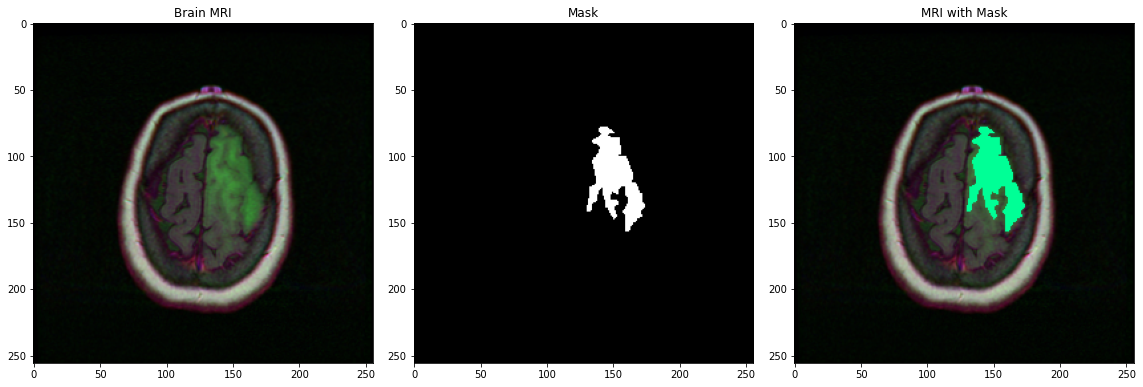

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(16, 9))

img = cv2.imread(brain_data.image_path[i])
axes.flat[0].title.set_text("Brain MRI")
axes.flat[0].imshow(img)

mask = cv2.imread(brain_data.mask_path[i])[:, :, 2]
axes.flat[1].title.set_text("Mask")
axes.flat[1].imshow(mask, cmap='gray')

img[mask == 255] = (0, 255, 150)  # change pixel color at the position of mask
axes.flat[2].title.set_text("MRI with Mask")
axes.flat[2].imshow(img)

fig.tight_layout()

Реализуем датасет для дальнейшей обработки

In [21]:
class MRIDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.transforms = transforms
        self.imgs = df['image_path'].tolist()
        self.masks = df['mask_path'].tolist()

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)[:, :, 0]
        mask[mask == 255] = 1

        pos = np.where(mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes = torch.as_tensor([[xmin, ymin, xmax, ymax]])

        labels = torch.ones((1, ), dtype=torch.int64)
        masks = torch.as_tensor(np.array([mask]), dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((1, ), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [22]:
dataset = MRIDataset(brain_data.query('mask == 1'))

## Defining your model

Во вовремя работы мы будем использовать [Mask R-CNN](https://arxiv.org/abs/1703.06870), который базируется на[Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN это модель, который одновременно предсказывает позицию и класс объекта в фотографии. 

Mask R-CNN добавляет дополнительную ветку в Faster R-CNN, который также будет сегментировать маски для каждого объекта.


In [23]:
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

Подготовка скриптов для запуска

In [24]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 153215, done.
remote: Counting objects: 100% (5588/5588), done.
remote: Compressing objects: 100% (534/534), done.
remote: Total 153215 (delta 5089), reused 5470 (delta 5031), pack-reused 147627
Receiving objects: 100% (153215/153215), 299.83 MiB | 28.12 MiB/s, done.
Resolving deltas: 100% (135682/135682), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [25]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Создание DataLoader-ов

In [26]:
# use our dataset and defined transformations
dataset = MRIDataset(brain_data.query('mask == 1'), get_transform(train=True))
dataset_test = MRIDataset(brain_data.query('mask == 1'), get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-300])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-300:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Теперь инициализиуем саму модель и оптимизатор - SGD

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
model

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [29]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10


for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [  0/537]  eta: 0:13:16  lr: 0.000014  loss: 3.3602 (3.3602)  loss_classifier: 0.4142 (0.4142)  loss_box_reg: 0.0150 (0.0150)  loss_mask: 2.8861 (2.8861)  loss_objectness: 0.0410 (0.0410)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 1.4841  data: 0.2643  max mem: 1639
Epoch: [0]  [ 10/537]  eta: 0:04:38  lr: 0.000108  loss: 2.2210 (2.3435)  loss_classifier: 0.3923 (0.3703)  loss_box_reg: 0.0983 (0.0906)  loss_mask: 1.6196 (1.8375)  loss_objectness: 0.0304 (0.0387)  loss_rpn_box_reg: 0.0061 (0.0064)  time: 0.5287  data: 0.0313  max mem: 1913
Epoch: [0]  [ 20/537]  eta: 0:04:07  lr: 0.000201  loss: 1.3811 (1.8369)  loss_classifier: 0.2356 (0.2645)  loss_box_reg: 0.0703 (0.0824)  loss_mask: 1.0572 (1.4467)  loss_objectness: 0.0304 (0.0364)  loss_rpn_box_reg: 0.0068 (0.0070)  time: 0.4278  data: 0.0078  max mem: 1913
Epoch: [0]  [ 30/537]  eta: 0:03:55  lr: 0.000294  loss: 1.0549 (1.4920)  loss_classifier: 0.1015 (0.2072)  loss_box_reg: 0.0703 (0.0825)  loss_mask: 0.7249 (1.1566) 

KeyboardInterrupt: ignored

Посмотрим на примеры предсказаний

In [30]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [31]:
torch.save(model.state_dict(), 'segment.pth')

In [32]:
prediction[0]['masks'][0][0].shape

torch.Size([256, 256])

Вывод модели представляет из себя позицию объекта на фотографии, его класс и маску, а также уверенность модели

Посмотрим на пример

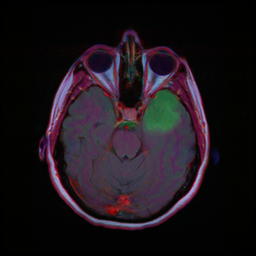

In [33]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

Посмотрим на предсказанную маску

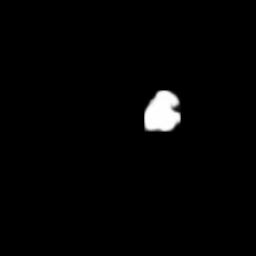

In [34]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [35]:
def get_mask(image_path, model):
    model.eval()

    img_original = cv2.imread(image_path)
    img, _ = get_transform(train=False)(img_original, {})

    with torch.no_grad():
        prediction = model([img.to(device)])

    if len(prediction) == 0 or len(prediction[0]['labels']) == 0:
        return np.zeros_like(img_original[:, :, 0])

    mask = prediction[0]['masks'][0][0]
    mask = mask.mul(255).byte().cpu().numpy()

    return mask

## Классификация + сегментация

Скачаем другой датасет - Brain Tumor Classification. Там нет выделения опухолей, но есть классы. Будем сегментировать с помощью прошлой сетки и классифицировать одновременно

In [36]:
!kaggle datasets download "sartajbhuvaji/brain-tumor-classification-mri"

 82% 71.0M/86.8M [00:00<00:00, 261MB/s]
100% 86.8M/86.8M [00:00<00:00, 268MB/s]


In [ ]:
!unzip brain-tumor-classification-mri.zip

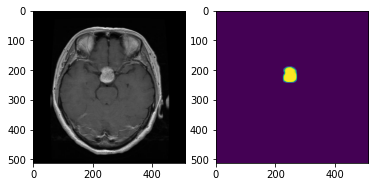

In [39]:
example_img_path = glob('Training/*/*.jpg')[2]
example_img = cv2.imread(example_img_path)
example_img_mask = get_mask(example_img_path, model)

_, axes = plt.subplots(1, 2)
axes[0].imshow(example_img)
axes[1].imshow(example_img_mask)

In [40]:
from collections import defaultdict
from tqdm.notebook import tqdm

In [41]:
!mkdir classification_masks

In [43]:
data = defaultdict(list)

for filepath in tqdm(glob('Training/*/*.jpg')):
    tumor_class = filepath.split('/')[-2]
    image_path = filepath

    mask = get_mask(image_path, model)
    image_name = os.path.basename(filepath)

    mask_path = 'classification_masks/' + image_name
    cv2.imwrite(mask_path, mask)

    data['mask_path'].append(mask_path)
    data['image_path'].append(image_path)
    data['tumor_name'].append(tumor_class)

df = pd.DataFrame(data)

  0%|          | 0/2870 [00:00<?, ?it/s]

In [47]:
from sklearn.preprocessing import LabelEncoder
tqdm.pandas()

In [45]:
df['tumor_class'] = LabelEncoder().fit_transform(df.tumor_name)

In [48]:
df['has_mask'] = df['mask_path'].progress_apply(lambda x: cv2.imread(x).max() > 0)

  0%|          | 0/2870 [00:00<?, ?it/s]

In [49]:
df.head()

,mask_path,image_path,tumor_name,tumor_class,has_mask
0,classification_masks/p (398).jpg,Training/pituitary_tumor/p (398).jpg,pituitary_tumor,3,True
1,classification_masks/p (153).jpg,Training/pituitary_tumor/p (153).jpg,pituitary_tumor,3,True
2,classification_masks/p (20).jpg,Training/pituitary_tumor/p (20).jpg,pituitary_tumor,3,True
3,classification_masks/p (336).jpg,Training/pituitary_tumor/p (336).jpg,pituitary_tumor,3,True
4,classification_masks/p (114).jpg,Training/pituitary_tumor/p (114).jpg,pituitary_tumor,3,True


In [50]:
df['has_mask'].value_counts()

True     2564
False     306
Name: has_mask, dtype: int64

In [51]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class MRIClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.transforms = transforms
        self.imgs = df['image_path'].tolist()
        self.masks = df['mask_path'].tolist()
        self.classes = df['tumor_class'].tolist()

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        tumor_class = self.classes[idx]

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)[:, :, 0]
        mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)[1]
        mask[mask == 255] = 1

        pos = np.where(mask)

        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        boxes = torch.as_tensor([[xmin, ymin, xmax, ymax]])

        labels = torch.as_tensor(np.array([tumor_class]), dtype=torch.int64)
        masks = torch.as_tensor(np.array([mask]), dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((1, ), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [52]:
# use our dataset and defined transformations
dataset = MRIClassificationDataset(df.query('has_mask == True'), get_transform(train=True))
dataset_test = MRIClassificationDataset(df.query('has_mask == True'), get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-400])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-400:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [53]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(df['tumor_class'].unique()) + 1

if 'classification_model' in locals():
    del classification_model

classification_model = get_instance_segmentation_model(num_classes)
classification_model.to(device)

params = [p for p in classification_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10


for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(classification_model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(classification_model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [   0/1082]  eta: 0:16:35  lr: 0.000010  loss: 3.3827 (3.3827)  loss_classifier: 1.6939 (1.6939)  loss_box_reg: 0.0009 (0.0009)  loss_mask: 1.5786 (1.5786)  loss_objectness: 0.1045 (0.1045)  loss_rpn_box_reg: 0.0048 (0.0048)  time: 0.9197  data: 0.4030  max mem: 3091
Epoch: [0]  [  10/1082]  eta: 0:09:37  lr: 0.000060  loss: 4.2533 (4.5757)  loss_classifier: 1.6258 (1.5488)  loss_box_reg: 0.0677 (0.0629)  loss_mask: 2.7651 (2.8999)  loss_objectness: 0.0417 (0.0608)  loss_rpn_box_reg: 0.0027 (0.0033)  time: 0.5387  data: 0.0423  max mem: 4043
Epoch: [0]  [  20/1082]  eta: 0:09:06  lr: 0.000110  loss: 2.7362 (3.3341)  loss_classifier: 1.1409 (1.1312)  loss_box_reg: 0.0613 (0.0580)  loss_mask: 1.5471 (2.0657)  loss_objectness: 0.0667 (0.0754)  loss_rpn_box_reg: 0.0032 (0.0038)  time: 0.4943  data: 0.0095  max mem: 4043
Epoch: [0]  [  30/1082]  eta: 0:08:44  lr: 0.000160  loss: 1.1354 (2.5871)  loss_classifier: 0.2144 (0.8109)  loss_box_reg: 0.0419 (0.0542)  loss_mask: 0.7568 (

In [64]:
torch.save(classification_model.state_dict(), 'classification_model.pth')

In [84]:
img_path = glob('Testing/*/*')[0]
img_original = cv2.imread(img_path)
img, _ = get_transform(train=False)(img_original, {})
classification_model.eval()

with torch.no_grad():
    prediction = classification_model([img.to(device)])

In [72]:
img_path

'Testing/pituitary_tumor/image(48).jpg'

In [80]:
class_to_name = dict(df[['tumor_class', 'tumor_name']].to_numpy())

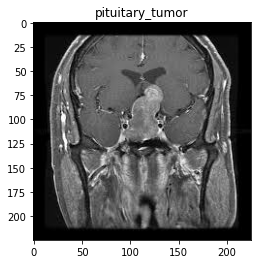

In [86]:
plt.title('pituitary_tumor')
plt.imshow(img_original)

In [137]:
def get_tumor_mask_and_class(img_path):
    img_original = cv2.imread(img_path)
    img, _ = get_transform(train=False)(img_original, {})
    
    with torch.no_grad():
        prediction = classification_model([img.to(device)])

    overall_desease = None
    total_mask = np.zeros_like(img_original)[:, :, 0]

    for label, mask, score in zip(prediction[0]['labels'], prediction[0]['masks'], prediction[0]['scores']):
        if label.item() != 2 and score.item() > 0.15 and (not overall_desease or label.item() == overall_desease):
            mask = mask[0].mul(255).byte().cpu().numpy()
            mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)[1]
            overall_desease = label.item()

            total_mask[mask == 255] = 255

    return {'mask': total_mask, 'label': overall_desease or 0}

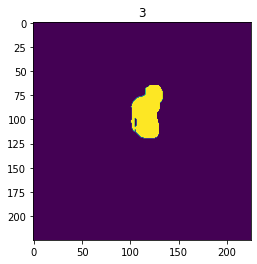

In [138]:
answer = get_tumor_mask_and_class(glob('Testing/*/*')[0])

plt.title(answer['label'])
plt.imshow(answer['mask'])

In [139]:
labels = [get_tumor_mask_and_class(f)['label'] for f in tqdm(df.image_path)]

  0%|          | 0/2870 [00:00<?, ?it/s]

In [140]:
from sklearn.metrics import accuracy_score

In [151]:
ll = list(map(lambda x: x if x else 0, labels))

In [152]:
accuracy_score(ll, df['tumor_class'])

0.6320557491289198